# eqc-models
## Pseudocode for optimization
```
# Define a model instance
instance = OptModel()
# define a solver instance
solver = Solver()
# request a solution
response = solver.solve(model)
display_results(response)
```

## Pseudocode for machine learning
```
# Define a model instance
instance = MLModel()
# fit to training data
instance.fit(knownX, knownY)
# make predictions
y = instance.predict(unownX)
```

# Simple Optimization Model
## Two variable polynomial

$$
-x^2+2xy-y^2
$$

## Imports

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("qci1.mplstyle")
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from eqc_models.base import PolynomialModel
from eqc_models.solvers.qciclient import Dirac1CloudSolver, Dirac3IntegerCloudSolver, Dirac3ContinuousCloudSolver

## Visualize

In [2]:
numpoints = 20
xlist = np.linspace(0, 1, numpoints)
ylist = np.linspace(0, 1, numpoints)
x, y = np.meshgrid(xlist, ylist)

In [3]:
z = -x**2 + 2*x*y - y**2

findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif' not found because none of the following families were found: Raleway
findfont: Generic family 'sans-serif'

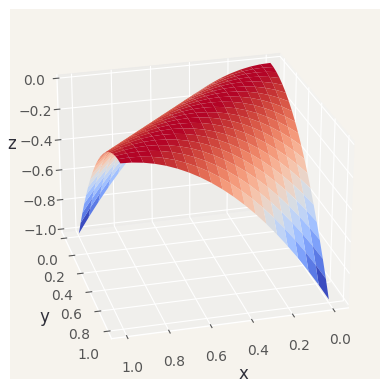

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
polycollection = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(25, 75)

## Model Definition

In [5]:
coefficients = [-1, 2, -1]
indices = [(0, 1), (1, 2), (0, 2)]

In [6]:
model = PolynomialModel(coefficients, indices)
model.upper_bound = np.ones((2, ))

## Dirac-3

In [7]:
solver = Dirac3IntegerCloudSolver()

In [8]:
response = solver.solve(model)

2025-03-14 23:01:00 - Dirac allocation balance = 0 s (unmetered)
2025-03-14 23:01:00 - Job submitted: job_id='67d5098c00e804f113aefca2'
2025-03-14 23:01:01 - QUEUED
2025-03-14 23:01:03 - COMPLETED
2025-03-14 23:01:06 - Dirac allocation balance = 0 s (unmetered)


In [9]:
response["results"]["solutions"]

[[0, 1]]

In [10]:
response = solver.solve(model, num_samples=5)

2025-03-14 23:01:08 - Dirac allocation balance = 0 s (unmetered)
2025-03-14 23:01:08 - Job submitted: job_id='67d5099400e804f113aefca3'
2025-03-14 23:01:08 - QUEUED
2025-03-14 23:01:11 - RUNNING
2025-03-14 23:01:16 - COMPLETED
2025-03-14 23:01:18 - Dirac allocation balance = 0 s (unmetered)


In [11]:
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

Solutions: [[1, 0], [0, 1]] Counts: [4, 1]


In [12]:
solver = Dirac1CloudSolver()
response = solver.solve(model, num_samples=5)
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

2025-03-14 23:01:20 - Dirac allocation balance = 0 s (unmetered)
2025-03-14 23:01:21 - Job submitted: job_id='67d509a000e804f113aefca5'
2025-03-14 23:01:21 - QUEUED
2025-03-14 23:01:28 - RUNNING
2025-03-14 23:02:39 - COMPLETED
2025-03-14 23:02:41 - Dirac allocation balance = 0 s (unmetered)
Solutions: [[0, 1], [1, 0]] Counts: [3, 2]


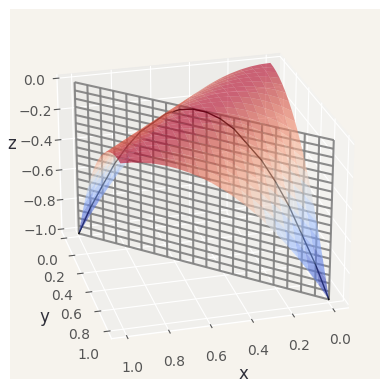

In [13]:
xsel = np.linspace(0, 1, numpoints)
zsel = np.linspace(-1, 0, numpoints)
xsel, zsel = np.meshgrid(xsel, zsel)
ysel = 1 - xsel
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
polycollection1 = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.6)
polycollection2 = ax.plot_wireframe(xsel, ysel, zsel, color='gray', alpha=0.9)
sel = x + y == 1
xsel = x[sel]
ysel = y[sel]
zsel = z[sel]
ax.plot(xsel, ysel, zsel, linewidth=1, color='black')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(25, 75)

In [14]:
solver = Dirac3ContinuousCloudSolver()
response = solver.solve(model, sum_constraint=1, relaxation_schedule=1, num_samples=5, solution_precision=0.1)
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

2025-03-14 23:02:43 - Dirac allocation balance = 0 s (unmetered)
2025-03-14 23:02:44 - Job submitted: job_id='67d509f300e804f113aefca7'
2025-03-14 23:02:44 - QUEUED
2025-03-14 23:02:46 - RUNNING
2025-03-14 23:04:09 - COMPLETED
2025-03-14 23:04:12 - Dirac allocation balance = 0 s (unmetered)
Solutions: [[0, 1], [1, 0]] Counts: [4, 1]


# Simple Classification Model

| X1 | X2 | Y |
|----|----|---|
| 0.25 | 0.25 | -1 |
| 0.75 | 0.25 | -1 |
| 0.75 | 0.75 | 1 |
| 0.5 | 0 | -1 |
| 0.5 | 1 | 1 |
| 1 | 1 | 1 |

In [15]:
from eqc_models.ml.classifierqboost import QBoostClassifier

In [16]:
X = np.array([[ 0.25, 0.25],
              [0.75, 0.25],
              [0.75, 0.75],
              [0.5, 0],
              [0.5, 1],
             [1, 1]])
y = np.array([-1, -1, 1, -1, 1, 1])

In [17]:
qboost = QBoostClassifier(num_samples=1,relaxation_schedule=1,lambda_coef=0.0, weak_cls_strategy="sequential")

In [18]:
qboost.fit(X, y)

Runtime of _build_weak_classifiers_sq: 0.03 seconds!
Built 3 weak classifiers!
Runtime of get_hamiltonian: 0.04 seconds!
2025-03-14 23:04:16 - Dirac allocation balance = 0 s (unmetered)
2025-03-14 23:04:17 - Job submitted: job_id='67d50a5000e804f113aefcab'
2025-03-14 23:04:17 - QUEUED
2025-03-14 23:04:19 - RUNNING
2025-03-14 23:04:30 - COMPLETED
2025-03-14 23:04:32 - Dirac allocation balance = 0 s (unmetered)
{'job_info': {'job_id': '67d50a5000e804f113aefcab', 'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '67d50a50236cc2225ac90c62'}}, 'device_config': {'dirac-3_normalized_qudit': {'num_samples': 1, 'relaxation_schedule': 1, 'solution_precision': 1, 'sum_constraint': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-03-15T05:04:16.845Z', 'queued_at_rfc3339nano': '2025-03-15T05:04:16.845Z', 'running_at_rfc3339nano': '2025-03-15T05:04:17.875Z', 'completed_at_rfc3339nano': '2025-03-15T05:04:27.512Z'}, 'job_result': {'file_id'

{'job_info': {'job_id': '67d50a5000e804f113aefcab',
  'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '67d50a50236cc2225ac90c62'}},
   'device_config': {'dirac-3_normalized_qudit': {'num_samples': 1,
     'relaxation_schedule': 1,
     'solution_precision': 1,
     'sum_constraint': 1}}},
  'job_status': {'submitted_at_rfc3339nano': '2025-03-15T05:04:16.845Z',
   'queued_at_rfc3339nano': '2025-03-15T05:04:16.845Z',
   'running_at_rfc3339nano': '2025-03-15T05:04:17.875Z',
   'completed_at_rfc3339nano': '2025-03-15T05:04:27.512Z'},
  'job_result': {'file_id': '67d50a5b236cc2225ac90c66', 'device_usage_s': 1}},
 'status': 'COMPLETED',
 'results': {'counts': [1],
  'energies': [-6],
  'solutions': [[8.03e-05, 0.5236221, 0.4762976]],
  'distilled_energies': [-6],
  'distilled_solutions': [[0, 1, 0]]}}

In [19]:
qboost.predict(X), y

(array([-1., -1.,  1., -1.,  1.,  1.]), array([-1, -1,  1, -1,  1,  1]))

In [20]:
qboost.predict(np.array([[1, 1], [0.2, 0.2], [0.6, 0.75], [1, 0], [0.6, 0.6]]))

array([ 1., -1.,  1., -1.,  1.])